# Download Data and install libraries 

In [ ]:
!wget http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/metis-5.1.0.tar.gz
!gunzip metis-5.1.0.tar.gz
!tar -xvf metis-5.1.0.tar
%cd /content/metis-5.1.0
#!makefile config shared=1
!make config shared=1
!make install
%cd ..

In [ ]:
!pip -q install tensorflow-addons
!pip -q install stellargraph
!pip -q install metis
!sudo /sbin/ldconfig -v
!export METIS_DLL=/usr/local/lib/libmetis.so

In [ ]:
##download KeyBert author embeddings
!gdown --id 134bmQq3LBVB-3o6l67-Bk0p3dGyrzmYi
## download author d2v embeddings
!gdown --id 1aoVxttcsLHrOKyHxPi9-ePaz-9Ynqa2z
## download Altegrad (graph data)
!gdown --id "1zAHe0nRAxzTsrBm3pNfqjQZeHd-uKgTd"
!unzip -q -o "/content/altegrad-2020.zip"

In [ ]:
import networkx as nx

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import ClusterNodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN
from stellargraph import globalvar

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import Lookahead,NovoGrad

import pandas as pd
import numpy as np
from sklearn import model_selection


# Load data

In [ ]:
## use keybert embeddings
pd_embeds = pd.read_csv("author_embeds_bert768.csv",compression='gzip')

## if you want to use Doc2vec embeddings.
#pd_embeds = pd.read_csv("author_embeddings_d2v.csv")
#######################

pd_embeds.set_index('authorID',inplace=True)
G_nx = nx.read_edgelist('collaboration_network.edgelist', delimiter=' ', nodetype=int)
G = StellarGraph.from_networkx(G_nx,node_features=pd_embeds, node_type_default="author", edge_type_default="cites")

pd_embeds.head()

,auth_embed_0,auth_embed_1,auth_embed_2,auth_embed_3,auth_embed_4,auth_embed_5,auth_embed_6,auth_embed_7,auth_embed_8,auth_embed_9,auth_embed_10,auth_embed_11,auth_embed_12,auth_embed_13,auth_embed_14,auth_embed_15,auth_embed_16,auth_embed_17,auth_embed_18,auth_embed_19,auth_embed_20,auth_embed_21,auth_embed_22,auth_embed_23,auth_embed_24,auth_embed_25,auth_embed_26,auth_embed_27,auth_embed_28,auth_embed_29,auth_embed_30,auth_embed_31,auth_embed_32,auth_embed_33,auth_embed_34,auth_embed_35,auth_embed_36,auth_embed_37,auth_embed_38,auth_embed_39,...,auth_embed_728,auth_embed_729,auth_embed_730,auth_embed_731,auth_embed_732,auth_embed_733,auth_embed_734,auth_embed_735,auth_embed_736,auth_embed_737,auth_embed_738,auth_embed_739,auth_embed_740,auth_embed_741,auth_embed_742,auth_embed_743,auth_embed_744,auth_embed_745,auth_embed_746,auth_embed_747,auth_embed_748,auth_embed_749,auth_embed_750,auth_embed_751,auth_embed_752,auth_embed_753,auth_embed_754,auth_embed_755,auth_embed_756,auth_embed_757,auth_embed_758,auth_embed_759,auth_embed_760,auth_embed_761,auth_embed_762,auth_embed_763,auth_embed_764,auth_embed_765,auth_embed_766,auth_embed_767
authorID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2108281488,-0.173046,0.393209,1.831028,0.371120,0.242482,-0.495411,-0.726133,0.042257,0.460925,-0.613946,-0.336119,0.582738,-0.155096,0.496062,-0.131147,0.084022,-1.124881,-0.140933,-0.074926,0.084837,-0.253605,-0.096266,-0.329991,0.012299,0.851879,-0.130658,-0.248079,0.121888,-0.085081,-0.159354,-0.362353,0.105696,-0.159798,-0.924181,-0.654802,0.344883,0.286669,-0.077704,0.173877,0.154905,...,-0.598010,-0.826115,1.719798,-0.761064,0.179567,0.640446,0.892722,0.733161,0.066956,0.232464,-0.026667,-0.693748,-0.937065,0.354889,-0.028239,0.696455,-0.446061,0.024826,0.676388,0.156983,-0.157734,0.097707,0.034603,-0.720089,0.414393,0.288075,-0.383244,0.190391,-0.330003,0.187892,-0.281891,-0.852649,-0.476081,-0.633179,-0.690824,-0.123956,0.156237,-0.852115,-1.495437,0.033236
2595221017,-0.197502,-0.064884,1.619865,-0.014593,0.792456,-0.864575,-0.037857,-0.165942,0.276517,-0.555294,-0.631644,0.116087,-0.433079,0.563198,-0.049755,0.489740,-0.389780,0.468629,-0.035671,-0.259494,-0.996263,0.508401,0.713443,-0.176310,0.682409,0.020635,-0.100275,0.634538,-0.272070,0.307866,0.021029,-0.364701,0.281459,-0.348118,-0.306025,0.015887,0.131905,-0.432933,0.109667,-0.089357,...,-0.676947,-0.555962,-0.249646,-0.447208,-0.038728,0.235958,0.978269,0.097761,0.015489,-0.308050,-0.176071,-0.521514,-0.589157,-0.882482,-0.884801,0.661087,-0.235123,-0.218746,0.215607,0.418752,-0.721329,0.268213,0.336433,-0.037905,0.255193,0.882667,0.473684,0.300780,-0.686156,-0.092590,-0.650778,-1.114661,-0.039282,-0.118444,-0.244923,-0.153532,0.087446,0.042333,-0.823323,0.500721
2097270384,-0.192959,0.001563,1.654724,0.365408,0.396445,-0.608603,-0.352275,0.338049,-0.120389,-0.371518,-0.578296,0.462430,-0.789411,0.935133,0.549331,0.293660,-1.135520,0.178950,-0.177027,0.015445,-0.037963,-0.215782,-0.749321,0.028821,0.997122,0.002454,-0.392629,-0.169500,-0.804588,-0.054057,-0.848934,0.142752,0.187889,-0.549464,-0.328108,0.217560,-0.149524,-0.380249,0.418266,-0.326569,...,-0.746994,-0.469232,1.150694,-0.748614,0.096924,0.493252,-0.018203,-0.224732,0.192401,0.102611,-0.700352,-0.320948,-0.523485,-0.306408,-0.087058,0.075169,-0.273571,0.307482,1.067765,0.241145,-0.763631,0.658328,-0.081867,-1.038291,0.137976,0.870237,-0.258353,0.226808,-0.747607,-0.322230,-0.310240,-0.333399,-0.976173,0.048537,-0.065136,-0.617560,-0.023539,-0.869433,-0.564192,0.158580
2147216009,-0.985928,0.539726,0.853956,0.542073,0.184018,0.101193,-0.681880,-0.936817,0.359112,-0.898177,-0.627917,0.304435,0.010130,-0.132877,0.081372,0.354781,-0.613645,-0.981481,-0.308267,0.090581,0.293163,0.272516,-0.246858,-0.738789,0.771049,0.276306,-0.216015,0.419478,-1.267514,0.540901,-0.663147,0.165398,-0.097579,-0.501034,0.048533,0.016264,0.941655,-0.000413,0.037218,0.035471,...,-0.692499,-0.722468,0.3

(array([3931., 2805., 2104., 4483., 2677., 3257., 2180., 1202.,  458.,
          27.]),
 array([0.        , 0.42177835, 0.8435567 , 1.2653351 , 1.6871134 ,
        2.1088917 , 2.5306702 , 2.9524484 , 3.3742268 , 3.796005  ,
        4.2177835 ], dtype=float32),
 <a list of 10 Patch objects>)

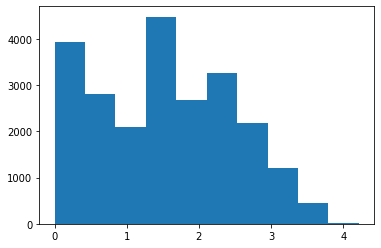

In [ ]:
import matplotlib.pyplot as plt

targets = pd.read_csv('train.csv', dtype={'authorID': np.int64, 'h_index': np.float32})

targets.set_index("authorID",inplace=True)
# Use scikit-learn to compute training and test sets
train_targets, test_targets = model_selection.train_test_split(targets, test_size=0.05)

from scipy.stats import boxcox
y = targets["h_index"].values
y_sc,ld= boxcox(y)
targets_sc = pd.DataFrame(y_sc,index=targets.index)
train_targets_sc, test_targets_sc = model_selection.train_test_split(targets_sc, test_size=0.2)
plt.hist(targets_sc.values)

#plt.hist(targets.values)

h_index
1.0        3931
2.0        2805
3.0        2104
4.0        1780
5.0        1488
           ... 
92.0          1
91.0          1
89.0          1
88.0          1
163.0         1
Length: 107, dtype: int64

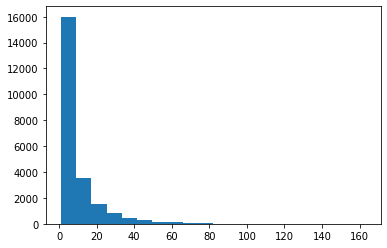

In [ ]:
targets.shape
plt.hist(targets.values,bins=20)
targets.value_counts()

In [ ]:
## define custom losses for training 

def real_mae(y_true,y_pred):
      return K.mean(K.abs(tf.math.round(y_pred)-y_true))

def inv_boxcox(y):
  return K.exp(K.log(ld * y + 1 )/ld)

def scaled_mae(y_true,y_pred):
  """ To use with scaled targets"""
  y_true = inv_boxcox(y_true)
  y_pred = inv_boxcox(y_pred)
  return real_mae(y_true,y_pred)


In [ ]:
# We are going to use the METIS clustering algorith,

""" Here we break the graph into equal sized subgraphs 

This allows for batch training on the graph and avoids memory overflows"""

import metis

number_of_clusters = 5  # the number of clusters/subgraphs
clusters_per_batch = 1  # combine two cluster per batch
node_ids = np.array(G.nodes())

###############

lil_adj = G.to_adjacency_matrix().tolil()
adjlist = [tuple(neighbours) for neighbours in lil_adj.rows]

edgecuts, parts = metis.part_graph(adjlist, number_of_clusters)
parts = np.array(parts)
clusters = []
cluster_ids = np.unique(parts)
for cluster_id in cluster_ids:
    mask = np.where(parts == cluster_id)
    clusters.append(node_ids[mask])

###########


def get_cluster_gen():
  cluster_generator = ClusterNodeGenerator(G, clusters=clusters, q=clusters_per_batch, lam=0.1)
  return cluster_generator

def get_full_batch_gen(model="gat"):
  full_batch_generator = FullBatchNodeGenerator(G, method=model)
  return full_batch_generator


Graph clustering using the METIS algorithm.


# Simple GNN

In [ ]:
def create_model(generator,mtype="gcn"):

  
  if mtype == "gcn":
    gnn = GCN(
    layer_sizes=[124, 124], activations=["elu", "elu"], generator=generator, dropout=0.5)

  if mtype == "gat":
    gnn = sg.layer.GAT(layer_sizes=[128,128], activations=['elu','elu'],attn_heads=2,in_dropout=0.5,
        attn_dropout=0.5,generator=generator)
  

  x_inp, x_out = gnn.in_out_tensors() # create the input and output TensorFlow tensors

  # use TensorFlow Keras to add a layer to compute the (one-hot) predictions
  predictions = tf.keras.layers.Dense(units=1, activation="relu")(x_out)

  # use the input and output tensors to create a TensorFlow Keras model
  model = tf.keras.Model(inputs=x_inp, outputs=predictions)


  ### Wrap the model with tf function to avoid OOM
  model.call = tf.function(model.call)

  return model


def fit_model(mtype='gcn',y_normalized=True,full_batch=False):

  

  if full_batch: generator = full_batch_generator ### train with the full graph as a batch
  else : generator = cluster_generator ### break the graph into smaller mini batches

  model = create_model(generator,mtype)
  optimizer = Lookahead(NovoGrad())
  #optimizer = Lookahead(Adam())
  #optimizer = Adam(lr=1e-3)

  if y_normalized : 
    # train with log normalized targets
    model.compile(optimizer, loss="mae",metrics=[scaled_mae])
    model.fit(generator.flow(train_targets_sc.index, train_targets_sc),validation_data = generator.flow(test_targets_sc.index, test_targets_sc), epochs=500)
  
  else : 

    model.compile(optimizer, loss="mae",metrics=[real_mae])
    model.fit(generator.flow(train_targets.index, train_targets),validation_data = generator.flow(test_targets.index, test_targets), epochs=500)
  

  return model

trained_model = fit_model(y_normalized=True,full_batch=True,mtype='gat')

Epoch 1/500


InvalidArgumentError: ignored

# Pretraining with DGI:


In [ ]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

In [ ]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=True)
pretrained_model = GAT(layer_sizes=[64,64,64], activations=["relu","relu","relu"],attn_heads=3,attn_dropout=0.1,in_dropout=0.1,generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

In [ ]:
infomax = DeepGraphInfomax(pretrained_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor="loss", min_delta=1e-2, patience=20)
history = model.fit(gen, epochs=100, verbose=2, callbacks=[es])
plot_history(history)

In [ ]:
train_gen = fullbatch_generator.flow(train_targets.index, train_targets)
test_gen = fullbatch_generator.flow(test_targets.index, test_targets)

pretrained_x_in, pretrained_x_out = pretrained_model.in_out_tensors()
tuned_predictions = tf.keras.layers.Dense(units=1, activation="relu")(pretrained_x_out)
tuned_model = Model(inputs=pretrained_x_in, outputs=tuned_predictions)

tuned_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss="mae")
tuned_history = tuned_model.fit(
    train_gen,
    epochs=100,
    verbose=2,
    validation_data=test_gen,
)